Here we define parameters of the system, the type of forcing to be used and launch other code.

In [1]:
import numpy as np
from numpy import cos, sin, cosh, sinh, tanh, array,pi, exp,array,sqrt
from numpy.linalg import norm,solve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sdeint
import scipy.linalg
import scipy.io
from model import linearisedSystem,model,eigen,Usolve,Lsolve
import time
from joblib import Parallel,delayed
plt.rc('font', size=15)          # controls default text sizes


In [2]:
# Define initial paramters
T = 15
N = 601
t = np.linspace(-T,T,N)
# parametrs
k = 1 # damping coefficient
D = lambda v : k*v #linear damping
h = 1 # potential parameter, need h>0
seednumber = 123456789

f,Aplus, Aminus, xplus, xminus = model(h,k,D)    # the vector field, matrices for linearised systems at equilibria, and equilibria
dt = 2*T/N
Pplus,Pplusinv,Pminus,Pinvminus,lambda2, omega, lambda3, lambda4  =  eigen(h,k)




In [3]:

# # Forcing function
# name = 'periodic'
# g = lambda t: np.array([0 ,0 ,0 ,cos(omega*t)])

# name = 'autonomous'
# g = lambda t: np.array([0 ,0 ,0 ,0])


name='quasi_periodic'
g = lambda t: np.array([0,0,0,np.cos(np.sqrt(2)*t)+2*np.cos(4*t)])


Create stochastic forcing
---
This is given by 
$$ \dot{\eta} = \begin{pmatrix}-\lambda & -\omega \\ \omega & -\lambda\end{pmatrix} \eta + B \xi $$

In [13]:
name='stochastic'

In [ ]:
import sdeint
a = 1.0
b = 0.8
tspan = np.linspace(-T, T, 100*N)
x0 = np.array([0,0])
M = np.array([[lambda3, -omega],[omega,lambda3]])

def mu(x, t):
    return np.matmul(M,x)

def sigma(x, t):
    return .5*np.array([[1, 1],[-1 ,1]])
rng = np.random.default_rng(12345)
noise = sdeint.itoint(mu, sigma, x0, tspan,generator=rng)

np.save(f'data_{name}/tspan.npy',tspan)
np.save(f'data_{name}/noise.npy',noise)

In [14]:
tspan=np.load(f'data_{name}/tspan.npy')
noise=np.load(f'data_{name}/noise.npy')

In [15]:

dense_noise = scipy.interpolate.CubicSpline(tspan,noise)

g = lambda t : np.matmul(np.array([[0,0],[0,0],[1,0],[0,1]]),dense_noise(t))


## Find Hyperbolic trajectories
----

In [4]:
def phi(t0,dt,x0):
    F = lambda t,x : f(x,t)+g(t)
    result = scipy.integrate.solve_ivp(F,[t0,t0+dt],x0,method = 'RK45',max_step = dt/50)
    result = result.y
    result = result.T
    return result[-1]

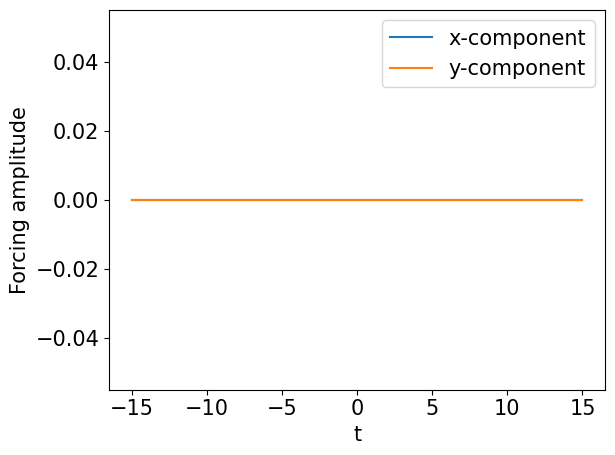

In [10]:
fig = plt.figure()
forcing  = [g(s) for s in t]
forcing = np.array(forcing)
plt.plot(t,forcing[:,2])
plt.plot(t,forcing[:,3])
# plt.title(f'External forcing: {name}')
plt.legend(('x-component','y-component'),loc='best')
plt.xlabel('t')
plt.ylabel('Forcing amplitude')
plt.tight_layout()
plt.savefig(f'figures/forcing_{name}.png')
plt.show()

In [ ]:
boundary_weight = 1

epsF = 1e-6
epsC = 1e-5
for sign in [-1,1]:
    print(f'side = {sign}')
    if sign == 1:
        A = Aplus
        P = Pplus
        Pinv = Pplusinv
        x0 = xplus
    elif sign == -1:
        A = Aminus
        P = Pminus
        Pinv = Pinvminus
        x0 = xminus
    def F(X,N):
        # N number of points taken, X is diplacement from x0
        Y = np.zeros((N,4))
        X = X.reshape((N,4))
        for i in range(0, N-1):
            Y[i] = phi(t[i],dt,X[i]+x0) - x0  - X[i+1]
            # Y[i] = phi(X[i] + x0,t[i]) - X[i+1] - x0   # ensures this is a trajectory.
        # Boundary conditions (stable/unstable coordinates are zero to keep bounded ( need displacement from equilibrium)
        Y[-1][1] = boundary_weight*Pinv.dot(X[0])[0]
        Y[-1][1] = boundary_weight*Pinv.dot(X[0])[1]
        Y[-1][2] = boundary_weight*Pinv.dot(X[0])[2]
        Y[-1][3] = boundary_weight*Pinv.dot(X[-1])[3] # unstable
        return Y.reshape(4*N)
    Dphi = scipy.linalg.expm(dt*A) # matrix exponential for linear flow displacement from x0
    # Derivative for linear system
    DF0 = np.zeros((4*N,4*N))
    for i in range(0,N-1):
        # find linear derivative
        DF0[4*i:4*i + 4, 4*i:4*i + 4] = Dphi
        DF0[4*i:4*i +4,4*i+4:4*i+8] = -np.eye(4)
    DF0[4*N-4,0:4] = boundary_weight*np.dot(Pinv.transpose(),array([1,0,0,0]))
    DF0[4*N-3,0:4] = boundary_weight*np.dot(Pinv.transpose(),array([0,1,0,0]))
    DF0[4*N-2,0:4] = boundary_weight*np.dot(Pinv.transpose(),array([0,0,1,0]))
    DF0[4*N-1,4*N-4:] = boundary_weight*np.dot(Pinv.transpose(),array([0,0,0,1]))
    Permute, L, U = scipy.linalg.lu(DF0) # numerical LU decomposition. This is computed once to maximise efficiency
    def DF0solve(y0):   # we only store the solution function to DF*h = y.
        x0 = np.transpose(Permute).dot(y0)
        return Usolve(Lsolve(x0,L),U)
    X0 = np.zeros((N,4))
    X = X0.reshape(-1)
    Fx = F(X0,N)
    delta = DF0solve(Fx)
    for iter in range(0,150):
        X = X - delta
        Fx = F(X,N)
        delta = DF0solve(Fx)
        norm_Fx = np.linalg.norm(Fx)
        print(f'Iteration = {iter} F_error = {norm_Fx}, x_error = {np.linalg.norm(delta)}')
        if norm_Fx > 1000 or (norm_Fx < epsF and np.linalg.norm(delta)< epsC):
            break
    if sign == 1:
        X_hyp_plus = X.reshape((len(t),4)) + x0
    elif sign == -1:
        X_hyp_minus = X.reshape((len(t),4)) + x0

In [ ]:
np.save(f'data_{name}/X_hyp_plus.npy',X_hyp_plus)
np.save(f'data_{name}/X_hyp_minus.npy',X_hyp_minus)


In [5]:
X_hyp_plus = np.load(f'data_{name}/X_hyp_plus.npy')
X_hyp_minus=np.load(f'data_{name}/X_hyp_minus.npy')


In [12]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(X_hyp_plus[:,0],X_hyp_plus[:,1], t,label = 'positive trajectory',linewidth=4)
ax.plot(X_hyp_minus[:,0],X_hyp_minus[:,1], t,label = 'negative trajectory',linewidth=4)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.view_init(elev=15,azim=-45)
plt.tight_layout()
plt.savefig(f'figures/hyp_traj_{name}.png')
plt.show()

## Stable manifold trajectories
---


In [6]:
Deltatminus = int(-np.log(10)/(dt*lambda3))
Deltatplus = int(np.log(10)/(dt*lambda4))
print(Deltatminus)
print(Deltatplus)

28
74


In [ ]:

M = 15
R = 1.5
q1,q2,q3 = np.meshgrid(np.linspace(-R,R,M),np.linspace(-R,R,M),np.linspace(-R,R,M))
q1=q1.reshape(-1)
q2=q2.reshape(-1)
q3 = q3.reshape(-1)
Q = np.vstack((q1,q2,q3)).T
j = int((N-1)/2)
start = time.time()
for sign in [-1,1]:
    if sign == 1:
        A = Aplus
        P = Pplus
        Pinv = Pplusinv
        X_hyp = X_hyp_plus
    elif sign == -1:
        A = Aminus
        P = Pminus
        Pinv = Pinvminus
        X_hyp = X_hyp_minus

    def F_S(X,q,j,imin,M):
        # N number of points taken, X is diplacement from x0
        Y = np.zeros((M,4))
        X = X.reshape((M,4))
        for i in range(0, M-1):
            Y[i] = phi(t[i],dt,X[i]+X_hyp[i+imin]) - X_hyp[i+imin]  - X[i+1]
            # Y[i] = phi(X[i] + x0,t[i]) - X[i+1] - x0   # ensures this is a trajectory.
        # Boundary conditions (stable/unstable coordinates are zero to keep bounded ( need displacement from equilibrium)
        Y[-1][1] = Pinv.dot(X[j-imin])[0] - q[0]
        Y[-1][1] = Pinv.dot(X[j-imin])[1] -q[1]
        Y[-1][2] = Pinv.dot(X[j-imin])[2] - q[2]
        Y[-1][3] = Pinv.dot(X[-1])[3] # unstable
        return Y.reshape(4*M)
    def get_DF0_Ssolve(j,imin,M):
        DF0_S = np.zeros((4*M,4*M))
        Dphi = scipy.linalg.expm(dt*A) # matrix exponential for linear flow displacement from x0

        j = j-imin
        for i in range(0,M-1):
            # find linear derivative
            DF0_S[4*i:4*i + 4, 4*i:4*i + 4] = Dphi
            DF0_S[4*i:4*i +4,4*i+4:4*i+8] = -np.eye(4)
        DF0_S[4*M-4,4*j:4*j+4] = np.dot(Pinv.transpose(),array([1,0,0,0]))
        DF0_S[4*M-3,4*j:4*j+4] = np.dot(Pinv.transpose(),array([0,1,0,0]))
        DF0_S[4*M-2,4*j:4*j+4] = np.dot(Pinv.transpose(),array([0,0,1,0]))
        DF0_S[4*M-1,4*M-4:] = np.dot(Pinv.transpose(),array([0,0,0,1]))
        Permute, L, U = scipy.linalg.lu(DF0_S) # numerical LU decomposition. This is computed once to maximise efficiency
        def DF0_Ssolve(y0):   # we only store the solution function to DF*h = y.
            x0 = np.transpose(Permute).dot(y0)
            return Usolve(Lsolve(x0,L),U)
        return DF0_Ssolve
    def Find_stable_trajectory(q,j,epsF =1e-5,epsC = 1e-5):
    # if __name__ == '__main__':    

        Deltatminus = int(-np.log(10)/(dt*lambda3))
        Deltatplus = int(np.log(10)/(dt*lambda4))
        imin = j -Deltatminus
        imax = j+ Deltatplus
        M = imax -imin + 1
        p_0 = np.matmul(P,np.hstack((q,0)))
        S = np.arange(imin,imax+1,1) - j
        X0 = [np.matmul(scipy.linalg.expm(s*dt*A),p_0) for s in S]
        X0 = np.array(X0)
        X = X0.reshape(-1)
        Fx = F_S(X,q,j,imin,M)
        DF0_Ssolve = get_DF0_Ssolve(j,imin,M)
        delta = DF0_Ssolve(Fx)
        for _ in range(0,100):
            X = X - delta
            Fx = F_S(X,q,j,imin,M)
            delta = DF0_Ssolve(Fx)
            norm_Fx = np.linalg.norm(Fx)
            print(f'F_error = {norm_Fx}, x_error = {np.linalg.norm(delta)}')
            if norm_Fx > 1000 or (norm_Fx < epsF and np.linalg.norm(delta)< epsC):
                break
        if (norm_Fx < epsF and np.linalg.norm(delta)< epsC):
            X_S = X.reshape((M,4)) + X_hyp[imin:imax+1]
            flag = True
        else:
            X_S = X0
            flag = False
        return X_S[j-imin],flag
    def get_point(q):
        X_S,flag = Find_stable_trajectory(q,j)
        p = X_S
        return p,flag
    SM = []
    # for q in Q:
    #     SM.append(get_point(q)) 
    SM = Parallel(n_jobs=-1)(delayed(get_point)(q) for q in Q)
    P = [p[0] for p in SM]
    flags = [p[1] for p in SM]
    if sign == 1:
        SM_plus = np.array(P)
        flags_plus = flags
    elif sign == -1:
        SM_minus = np.array(P)
        flags_minus = flags

elapsed = time.time() - start
print(f'Elapsed time = {elapsed:.1f}')

In [ ]:
print(np.mean(flags_plus))
print(np.mean(flags_minus))
np.save(f'data_{name}/Q.npy',Q)
np.save(f'data_{name}/SM_plus.npy',SM_plus)
np.save(f'data_{name}/SM_minus.npy',SM_minus)
np.save(f'data_{name}/flags_plus.npy',np.array(flags_plus))
np.save(f'data_{name}/flags_minus.npy',np.array(flags_minus))
np.save(f'data_{name}/Q.npy',Q)
np.save(f'data_{name}/SM_plus.npy',SM_plus)
np.save(f'data_{name}/SM_minus.npy',SM_minus)
np.save(f'data_{name}/flags_plus.npy',np.array(flags_plus))
np.save(f'data_{name}/flags_minus.npy',np.array(flags_minus))



In [7]:
SM_plus = np.load(f'data_{name}/SM_plus.npy')
SM_minus = np.load(f'data_{name}/SM_minus.npy')
Q = np.load(f'data_{name}/Q.npy')
flags_plus = np.load(f'data_{name}/flags_plus.npy')
flags_minus = np.load(f'data_{name}/flags_minus.npy')
v_y_plus  = scipy.interpolate.Rbf(SM_plus[flags_plus,0],SM_plus[flags_plus,1],SM_plus[flags_plus,2],SM_plus[flags_plus,3])
v_y_minus  = scipy.interpolate.Rbf(SM_minus[flags_minus,0],SM_minus[flags_minus,1],SM_minus[flags_minus,2],SM_minus[flags_minus,3])


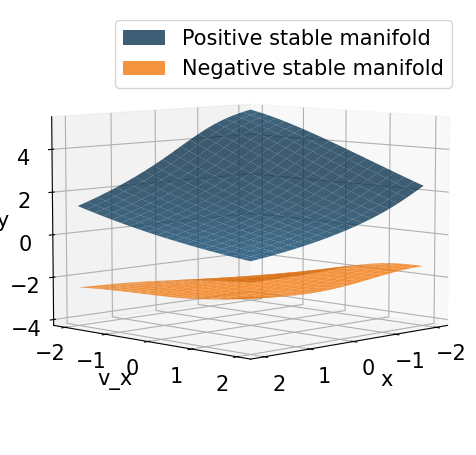

In [8]:
X,VX = np.meshgrid(np.linspace(-2,2,20),np.linspace(-2,2,20))
VY_plus = v_y_plus(X,0*X,VX)
VY_minus = v_y_minus(X,0*X,VX)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X,VX,VY_plus,alpha=0.8)
ax.plot_surface(X,VX,VY_minus,alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('v_x')
ax.set_zlabel('v_y')
ax.view_init(elev=6.5,azim=-45)
# plt.title('Stable manifolds in y=0,t=0')
ax.legend(('Positive stable manifold','Negative stable manifold'))
plt.tight_layout()
plt.savefig(f'figures/manifolds_{name}1.png')
ax.view_init(elev=6.5,azim=45)
plt.savefig(f'figures/manifolds_{name}2.png')
plt.show()

## Numerical experiments
----
Things to do here, test classification by straight integration (not too dividing manifold)


In [9]:


def is_not_capsize(y0):
    def event(t,y):
        return y[1]**2 - 10
    event.terminal = True
    F = lambda t,x : f(x,t)+g(t)
    res = solve_ivp (F, [0,2*T], y0 , method = "RK45" , events=[event],  max_step =dt/50 , rtol = 1e-12 )
    result = res.y
    result = result.T
    y = result[-1]
    print(y)
    return y[1]**2 < 10


In [10]:
points = np.random.rand(10000,4)
scale = np.array([[2, 0, 0,0],[0,2,0,0],[0,0,10,0],[0,0,0,10]])
points = np.matmul(scale,points.T-.5).T
capsize_flags = Parallel(n_jobs=-2)(delayed(is_not_capsize)(y0) for y0 in points)
np.save(f'data_{name}/points_full.npy',np.array(points))
np.save(f'data_{name}/capsize_flags_full.npy',np.array(capsize_flags))    

In [18]:
points = np.load(f'data_{name}/points_full.npy')
capsize_flags = np.load(f'data_{name}/capsize_flags_full.npy')


In [11]:
manifold_flags = []
for y0 in points:
    flag = y0[3] < v_y_plus(y0[0],y0[1],y0[2]) and y0[3] > v_y_minus(y0[0],y0[1],y0[2])#
    manifold_flags.append(flag)

In [12]:
capsize_flags = np.array(capsize_flags)
manifold_flags = np.array(manifold_flags)

accuracy = np.mean(capsize_flags == manifold_flags)
print(name)
print(f'accuracy = {accuracy}')
print(f'Sensitivity = {np.mean(manifold_flags[capsize_flags])}')
print(f'Specitivity = {np.mean(~manifold_flags[~capsize_flags])}')
%matplotlib qt

quasi_periodic
accuracy = 0.6841
Sensitivity = 0.5744095058687146
Specitivity = 0.9283639883833494


In [ ]:
# def is_not_capsize(y0):
#     return y0[3] < v_y_plus(y0[0],y0[1],y0[2]) and y0[3] > v_y_minus(y0[0],y0[1],y0[2])

In [30]:
name

'autonomous'

In [24]:
points = np.random.rand(1000,4)
scale = np.array([[2, 0, 0,0],[0,2,0,0],[0,0,10,0],[0,0,0,10]])
points = np.matmul(scale,points.T-.5).T
M=20
R = 1
X = np.linspace(-R,R,M)
fig,axs = plt.subplots(1,3)
fig.set_figwidth(12)
i=0
for y_val in [-0.5,0,0.5]:
    VY_plus = v_y_plus(X,0*X+y_val,0*X)
    VY_minus = v_y_minus(X,0*X+y_val,0*X)
    points[:,1] = 0*points[:,1] +y_val
    points[:,2] = 0*points[:,1] 
    capsize_flags = Parallel(n_jobs=-2)(delayed(is_not_capsize)(y0) for y0 in points)


    # fig = plt.figure()
    points = np.array(points)
    capsize_flags = np.array(capsize_flags)

    capsize_points = points[~capsize_flags,:]
    safe_points=  points[capsize_flags,:]
    # capsize_points = points[~manifold_flags,:]
    # safe_points=  points[manifold_flags,:]
    if i == 0:
        axs[i].scatter(capsize_points[:,0],capsize_points[:,3],color='r',alpha = 0.4,label='Capsize')
        axs[i].scatter(safe_points[:,0],safe_points[:,3],color='g',alpha = 0.4,label='Safe')
        # plt.title(f'y = {y_val}')
        axs[i].plot(X,VY_plus,color = 'b',label='Stable manifolds')
    else:
        axs[i].scatter(capsize_points[:,0],capsize_points[:,3],color='r',alpha = 0.4)
        axs[i].scatter(safe_points[:,0],safe_points[:,3],color='g',alpha = 0.4)
        # plt.title(f'y = {y_val}')
        axs[i].plot(X,VY_plus,color = 'b')
    axs[i].plot(X,VY_minus,color = 'b')
    axs[i].set_xlabel(r'$x$')
    axs[i].set_title(f'y={y_val},v_y=0')
    if i ==0:
        axs[i].set_ylabel(r'$v_x$')
    i+=1
fig.legend(bbox_to_anchor=(1,1),loc='upper left')
fig.tight_layout()
plt.savefig(f'figures/scatter_{name}_manifolds.png')
plt.show()

In [ ]:
M=25
X = np.linspace(-R,R,M)
VX = np.linspace(-R,R,M)
X,VX = np.meshgrid(X,VX)
VY_plus = v_y_plus(X,0*X,VX)
VY_minus = v_y_minus(X,0*X,VX)

fig = plt.figure()
points = np.array(points)
ax = fig.add_subplot(projection='3d')
capsize_points = points[~capsize_flags,:]
safe_points=  points[capsize_flags,:]
# capsize_points = points[~manifold_flags,:]
# safe_points=  points[manifold_flags,:]
ax.scatter(capsize_points[:,0],capsize_points[:,2],capsize_points[:,3],color='r',alpha = 0.4)
ax.scatter(safe_points[:,0],safe_points[:,2],safe_points[:,3],color='g',alpha = 0.4)

ax.plot_surface(X,VX,VY_plus,alpha = 0.5,color = 'b')
ax.plot_surface(X,VX,VY_minus,alpha = 0.5,color = 'b')
ax.set_xlabel('x')
ax.set_ylabel('v_x')
ax.set_zlabel('v_y')
plt.show()

## Calculating integrity measure
------
For this we will use the capsize criteria from the manifolds.

In [ ]:
H = lambda y: (.25*y[2]**2)/h + .5*y[3]**2 + .5*(y[1]**2 +.5*y[0]**2 - y[0]*y[1]**2)
def U(y0):
    return H(y0) <.25 and abs(y0[1]) <= 1

In [ ]:
points = np.random.rand(100000,4)
scale = np.array([[2, 0, 0,0],[0,2,0,0],[0,0,2*np.sqrt(h),0],[0,0,0,2*np.sqrt(2)]])
points = np.matmul(scale,points.T-.5).T
capsize_flags = []
for y0 in points:
    flag = y0[-3] < v_y_plus(y0[0],y0[1],y0[2]) and y0[-3] > v_y_minus(y0[0],y0[1],y0[2])#
    capsize_flags.append(flag)
volU = 163*np.pi*np.sqrt(2*h)/210
integrity_measure = np.mean(np.array(manifold_flags))*volU
print(f'For {name}: Integrity measure = {integrity_measure:.2f}, Relative integrity measure = {np.mean(np.array(manifold_flags)):.2f}')